In [1]:
%config InlineBackend.figure_format = 'retina'

from random import sample
import embedding_spaces as es
import seaborn as sns
import matplotlib.pyplot as plt

# Rating task (0-100) with 50 concepts
## With ratings dichotomized to 0 and 1

In [2]:
idxarrangs, concepts = es.preprocess_ratings()
display(concepts)

usable participants: 106
usable trials: 25440


concept        category
0    airplane         vehicle
1   alligator          animal
2       allow            verb
3        belt        clothing
4        bike         vehicle
5       brush  household item
6     buffalo          animal
7     cabinet       furniture
8       chair       furniture
9        clam          animal
10       coat        clothing
11      couch       furniture
12    cushion       furniture
13       desk       furniture
14       dish     kitchenware
15       doll  household item
16    dolphin          animal
17       door       furniture
18      dress        clothing
19   elephant          animal
20      exist            verb
21       find            verb
22       fork     kitchenware
23        fox          animal
24     gloves        clothing
25     hammer  household item
26      knife     kitchenware
27       lion          animal
28       make            verb
29      mouse          animal
30   necklace        clothing
31    octopus          animal
32       oven     kitchenware
33        pen  household item
34        pot     kitchenware
35    protect            verb
36      radio  household item
37   scissors     kitchenware
38       ship         vehicle
39      shirt        clothing
40      snail          animal
41   squirrel          animal
42  submarine         vehicle
43        toy  household item
44      train         vehicle
45     turtle          animal
46        use            verb
47      wagon         vehicle
48       work            verb
49      zebra          animal

### Choice embedding model inspired by Hebart et al. (2020)
This model has the following parts:
1. Input layer to ingest triad word indices
2. Embedding layer of shape n_words x n_words, for embedding triad choices
3. Small regularizing L2 penalty on the embeddings to keep the weights of unoserved triads from growing overly large
4. Custom lambda layer that computes projected match-to-middle triad output from embeddings
5. Sigmoid activation on the output node + binary cross-entropy loss on the predictions
6. Train until loss stops decreasing on consecutive epochs (i.e. early stopping)

In [3]:
embeddings = es.train_embeddings(idxarrangs, epochs=100, loss='cosine')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0epoch [00:00, ?epoch/s]

2023-01-13 15:30:12.235306: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


/Users/jvparidon/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


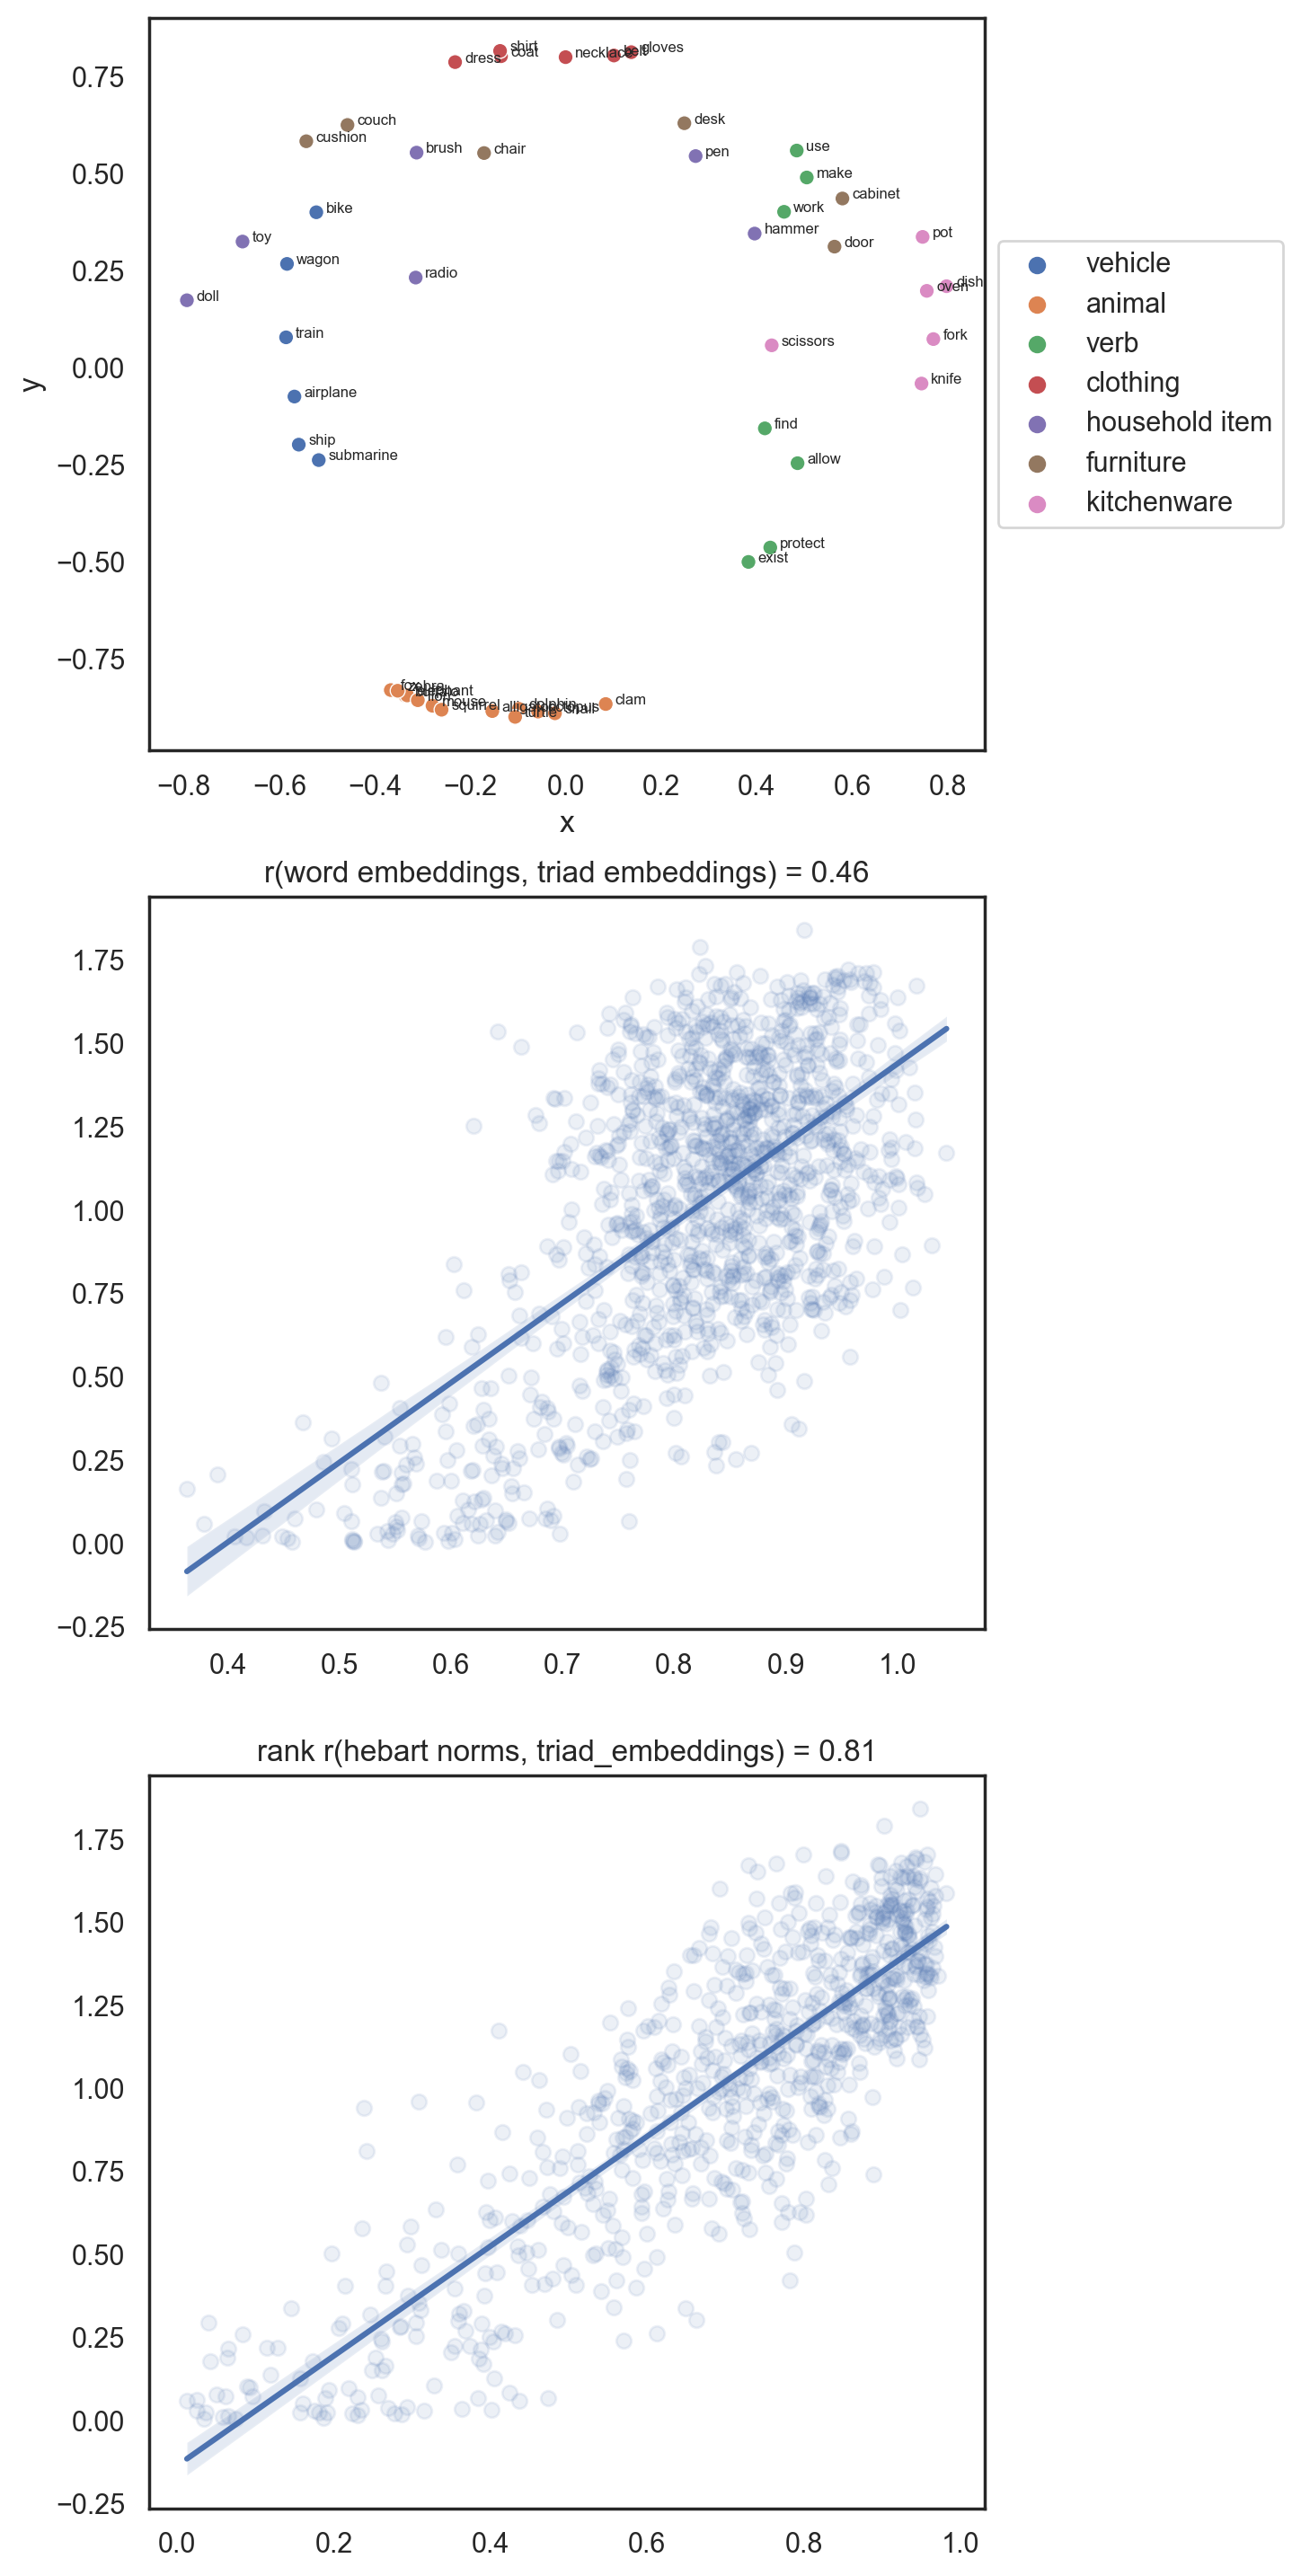

<Figure size 640x480 with 0 Axes>

In [4]:
es.evaluate_embeddings(embeddings, concepts)
#es.evaluate_embeddings(embeddings, concepts, categories=['verb'])
plt.savefig('ratingscale_50concept_embeds.pdf')

### Split-half correlations
To assess consistency of the ratings, we compute split half correlations as follows:
1. Split the dataset in half (by participants, to keep from cross-contiminating the halves)
2. Train choice embeddings on each half
3. Compute the pairwise distance matrix for each half
4. Rank correlate the distance matrices
5. Repeats steps 1-4 for multiple splits

In [5]:
# perform ten splits for stable estimate
print('split half rank correlation, sd across folds:')
es.splithalf_corr(idxarrangs, splits=10, epochs=100, loss='cosine')

split half rank correlation, sd across folds:


  0%|          | 0/10 [00:00<?, ?it/s]

(0.91, 0.01)

In [6]:
steps = 10
pp = []
r = []
sd = []

for i in range(steps):
    frac = (i + 1) / steps
    n = int(len(idxarrangs) / (1 / frac))
    print(f"split half correlation for first {n} participants:")
    corr = es.splithalf_corr(idxarrangs, splits=8, epochs=100, frac=frac)
    print(corr)
    pp.append(n)
    r.append(corr[0])
    sd.append(corr[1])

split half correlation for first 10 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.38, 0.23)
split half correlation for first 21 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.74, 0.1)
split half correlation for first 31 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.82, 0.08)
split half correlation for first 42 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.83, 0.03)
split half correlation for first 53 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.89, 0.03)
split half correlation for first 63 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.88, 0.04)
split half correlation for first 74 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.9, 0.03)
split half correlation for first 84 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.92, 0.02)
split half correlation for first 95 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.91, 0.02)
split half correlation for first 106 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.92, 0.04)


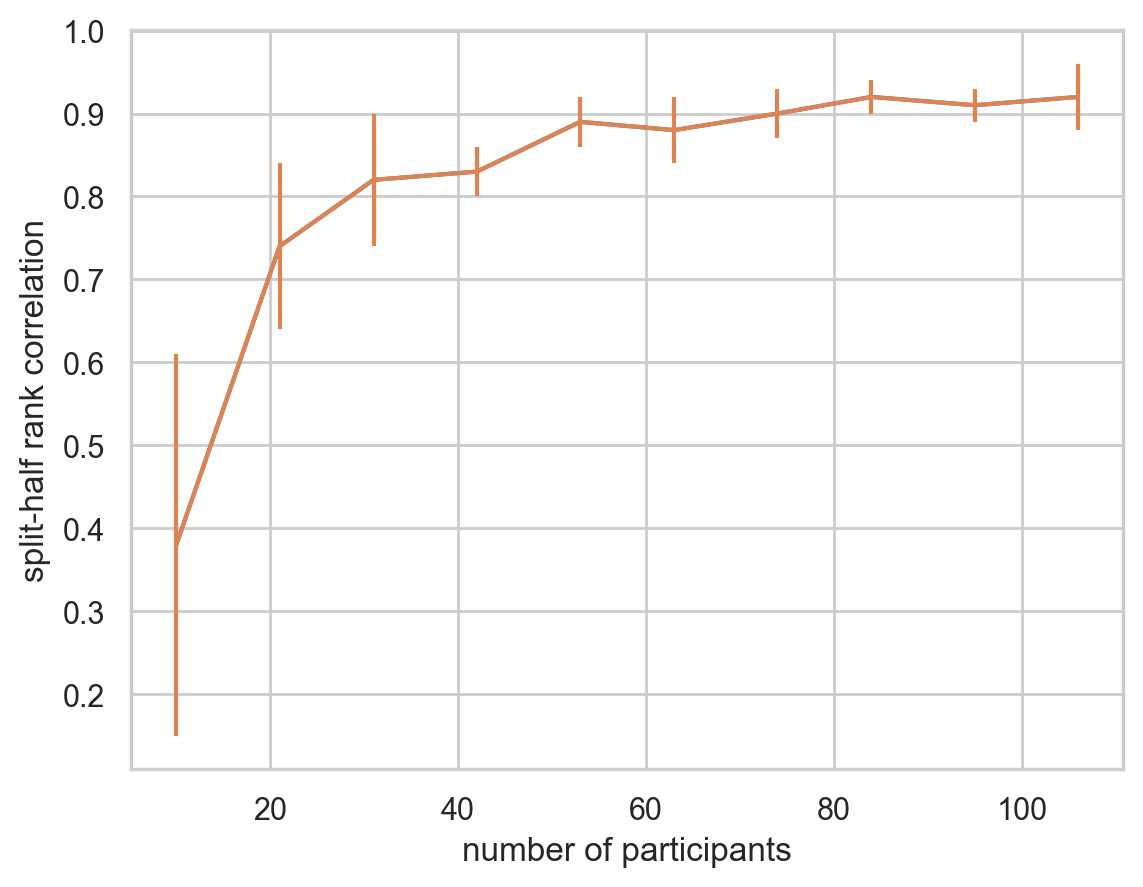

In [7]:
sns.set(style='whitegrid')
ax = sns.lineplot(x=pp, y=r)
ax.errorbar(x=pp, y=r, yerr=sd)
ax.set(ylabel='split-half rank correlation', xlabel='number of participants')
plt.savefig('splithalf_corr_50_concepts.pdf')

### Inverse MDS method from Kriegeskorte & Mur (2012)
This alternate method for generating distance matrices averages all the partial distance matrices together, and then iteratively minimizes the stress (i.e. difference) between that mean matrix and the original partial distance matrices.

In [8]:
mds = es.inverse_mds(idxarrangs)

/Users/jvparidon/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


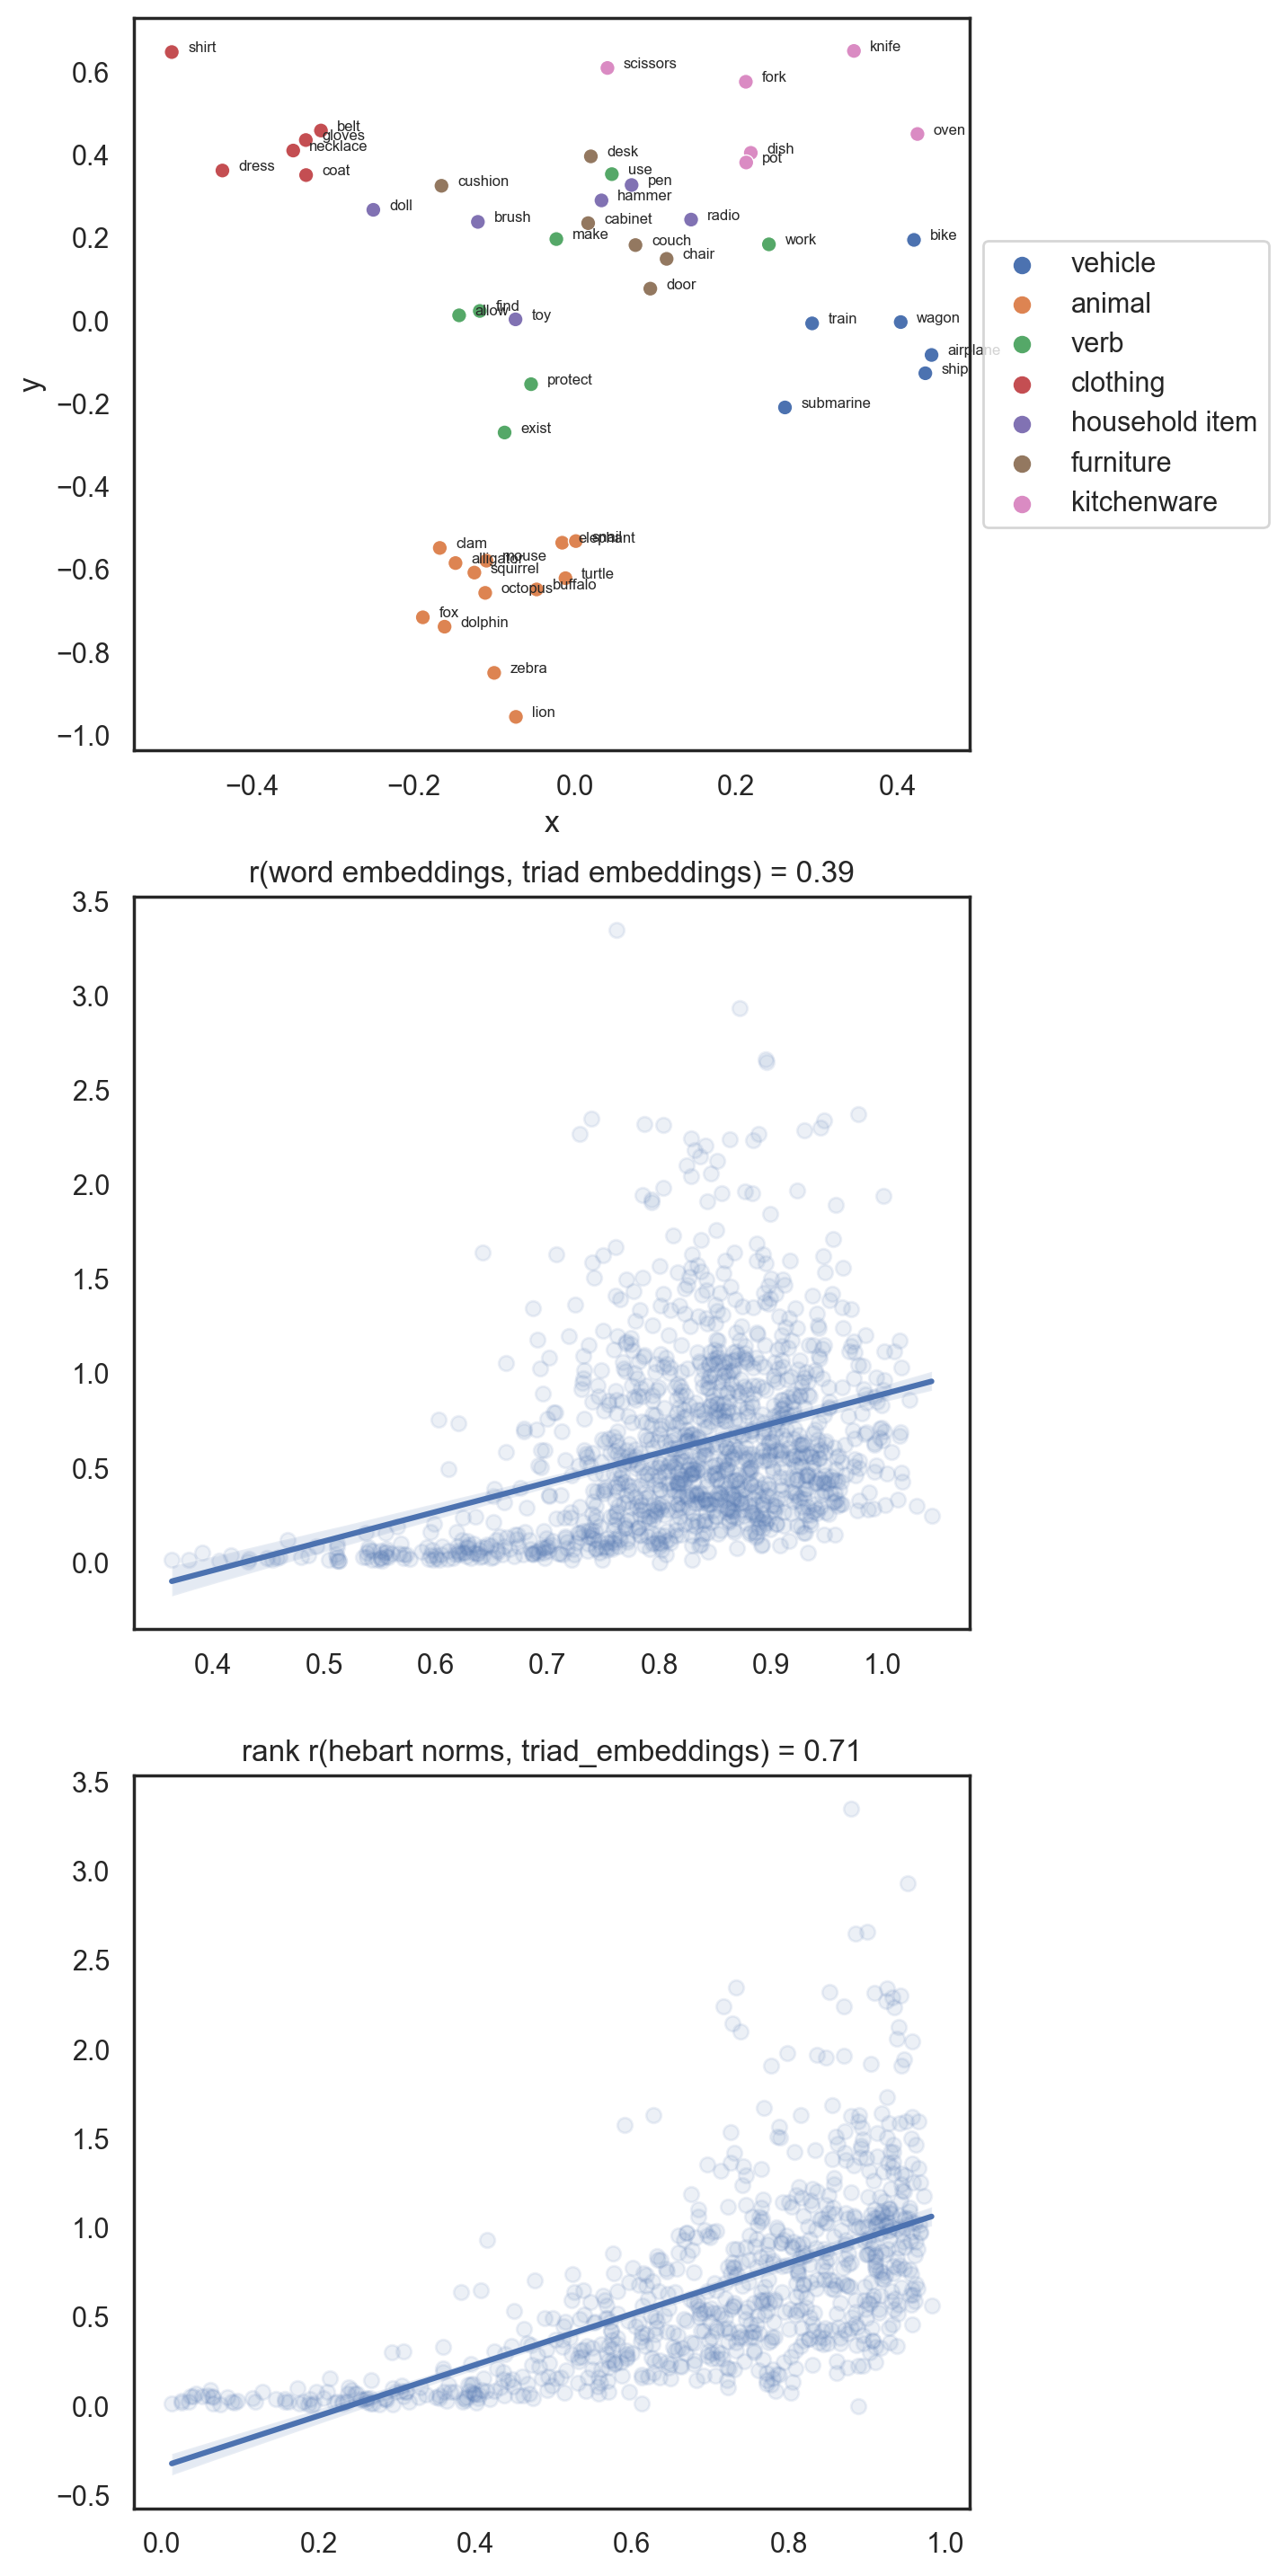

In [9]:
es.evaluate_embeddings(mds, concepts)

# Match-to-middle triad task with 110 concepts
## 0 (reject) and 1 (match) values

In [2]:
idxarrangs, concepts = es.preprocess_triads()
display(concepts)

usable participants: 32
usable trials: 5998


concept   category
0      cheap  adjective
1      chest   bodypart
2      child     person
3     clever  adjective
4    clothes       item
..       ...        ...
106    steal       verb
107    teach       verb
108      win       verb
109    white      color
110   yellow      color

[111 rows x 2 columns]

### Choice embedding model inspired by Hebart et al. (2020)

In [3]:
embeddings = es.train_embeddings(idxarrangs, epochs=100, loss='cosine')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0epoch [00:00, ?epoch/s]

2023-01-13 17:51:19.111171: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


/Users/jvparidon/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


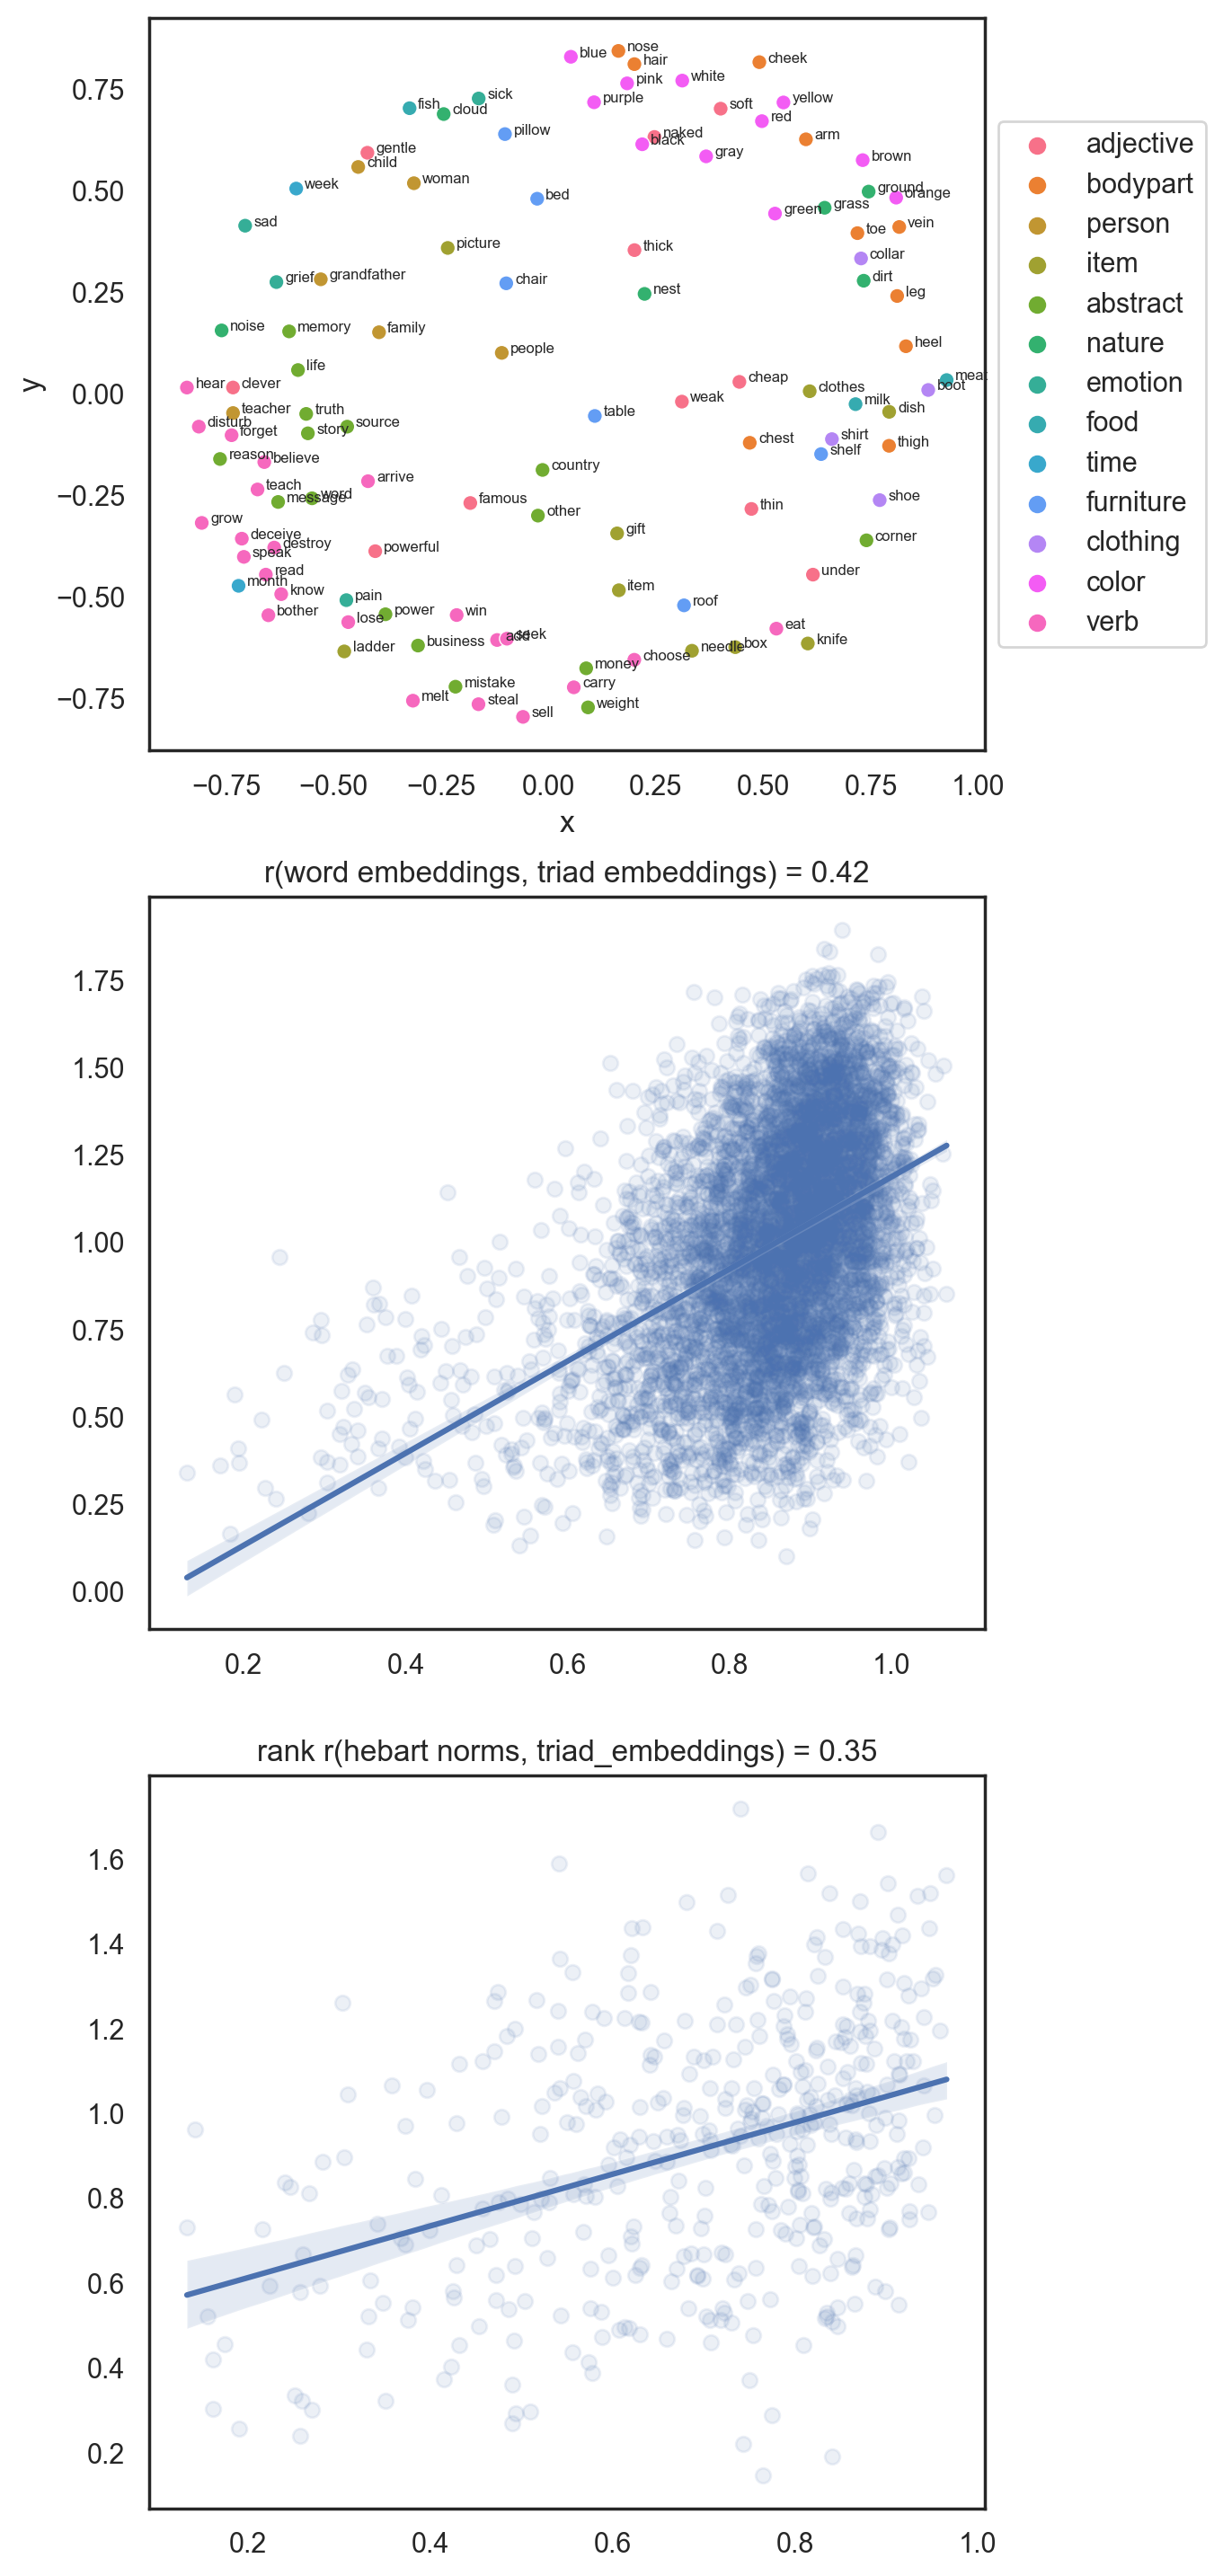

In [4]:
es.evaluate_embeddings(embeddings, concepts)

### Split-half correlations

In [5]:
# perform ten splits for stable estimate
print('split half rank correlation, sd across folds:')
es.splithalf_corr(idxarrangs, splits=10, epochs=100, loss='cosine')

split half rank correlation, sd across folds:


  0%|          | 0/10 [00:00<?, ?it/s]

(0.33, 0.03)

### Inverse MDS method from Kriegeskorte & Mur (2012)

In [6]:
mds = es.inverse_mds(idxarrangs)

/Users/jvparidon/Documents/Work/Projects/pastel-game/embedding_spaces.py:532: RuntimeWarning: invalid value encountered in divide
  mean_rdm = np.nan_to_num(rdm / evidence)
/Users/jvparidon/Documents/Work/Projects/pastel-game/embedding_spaces.py:561: RuntimeWarning: invalid value encountered in divide
  rdm = np.nan_to_num(rdm / evidence)


/Users/jvparidon/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


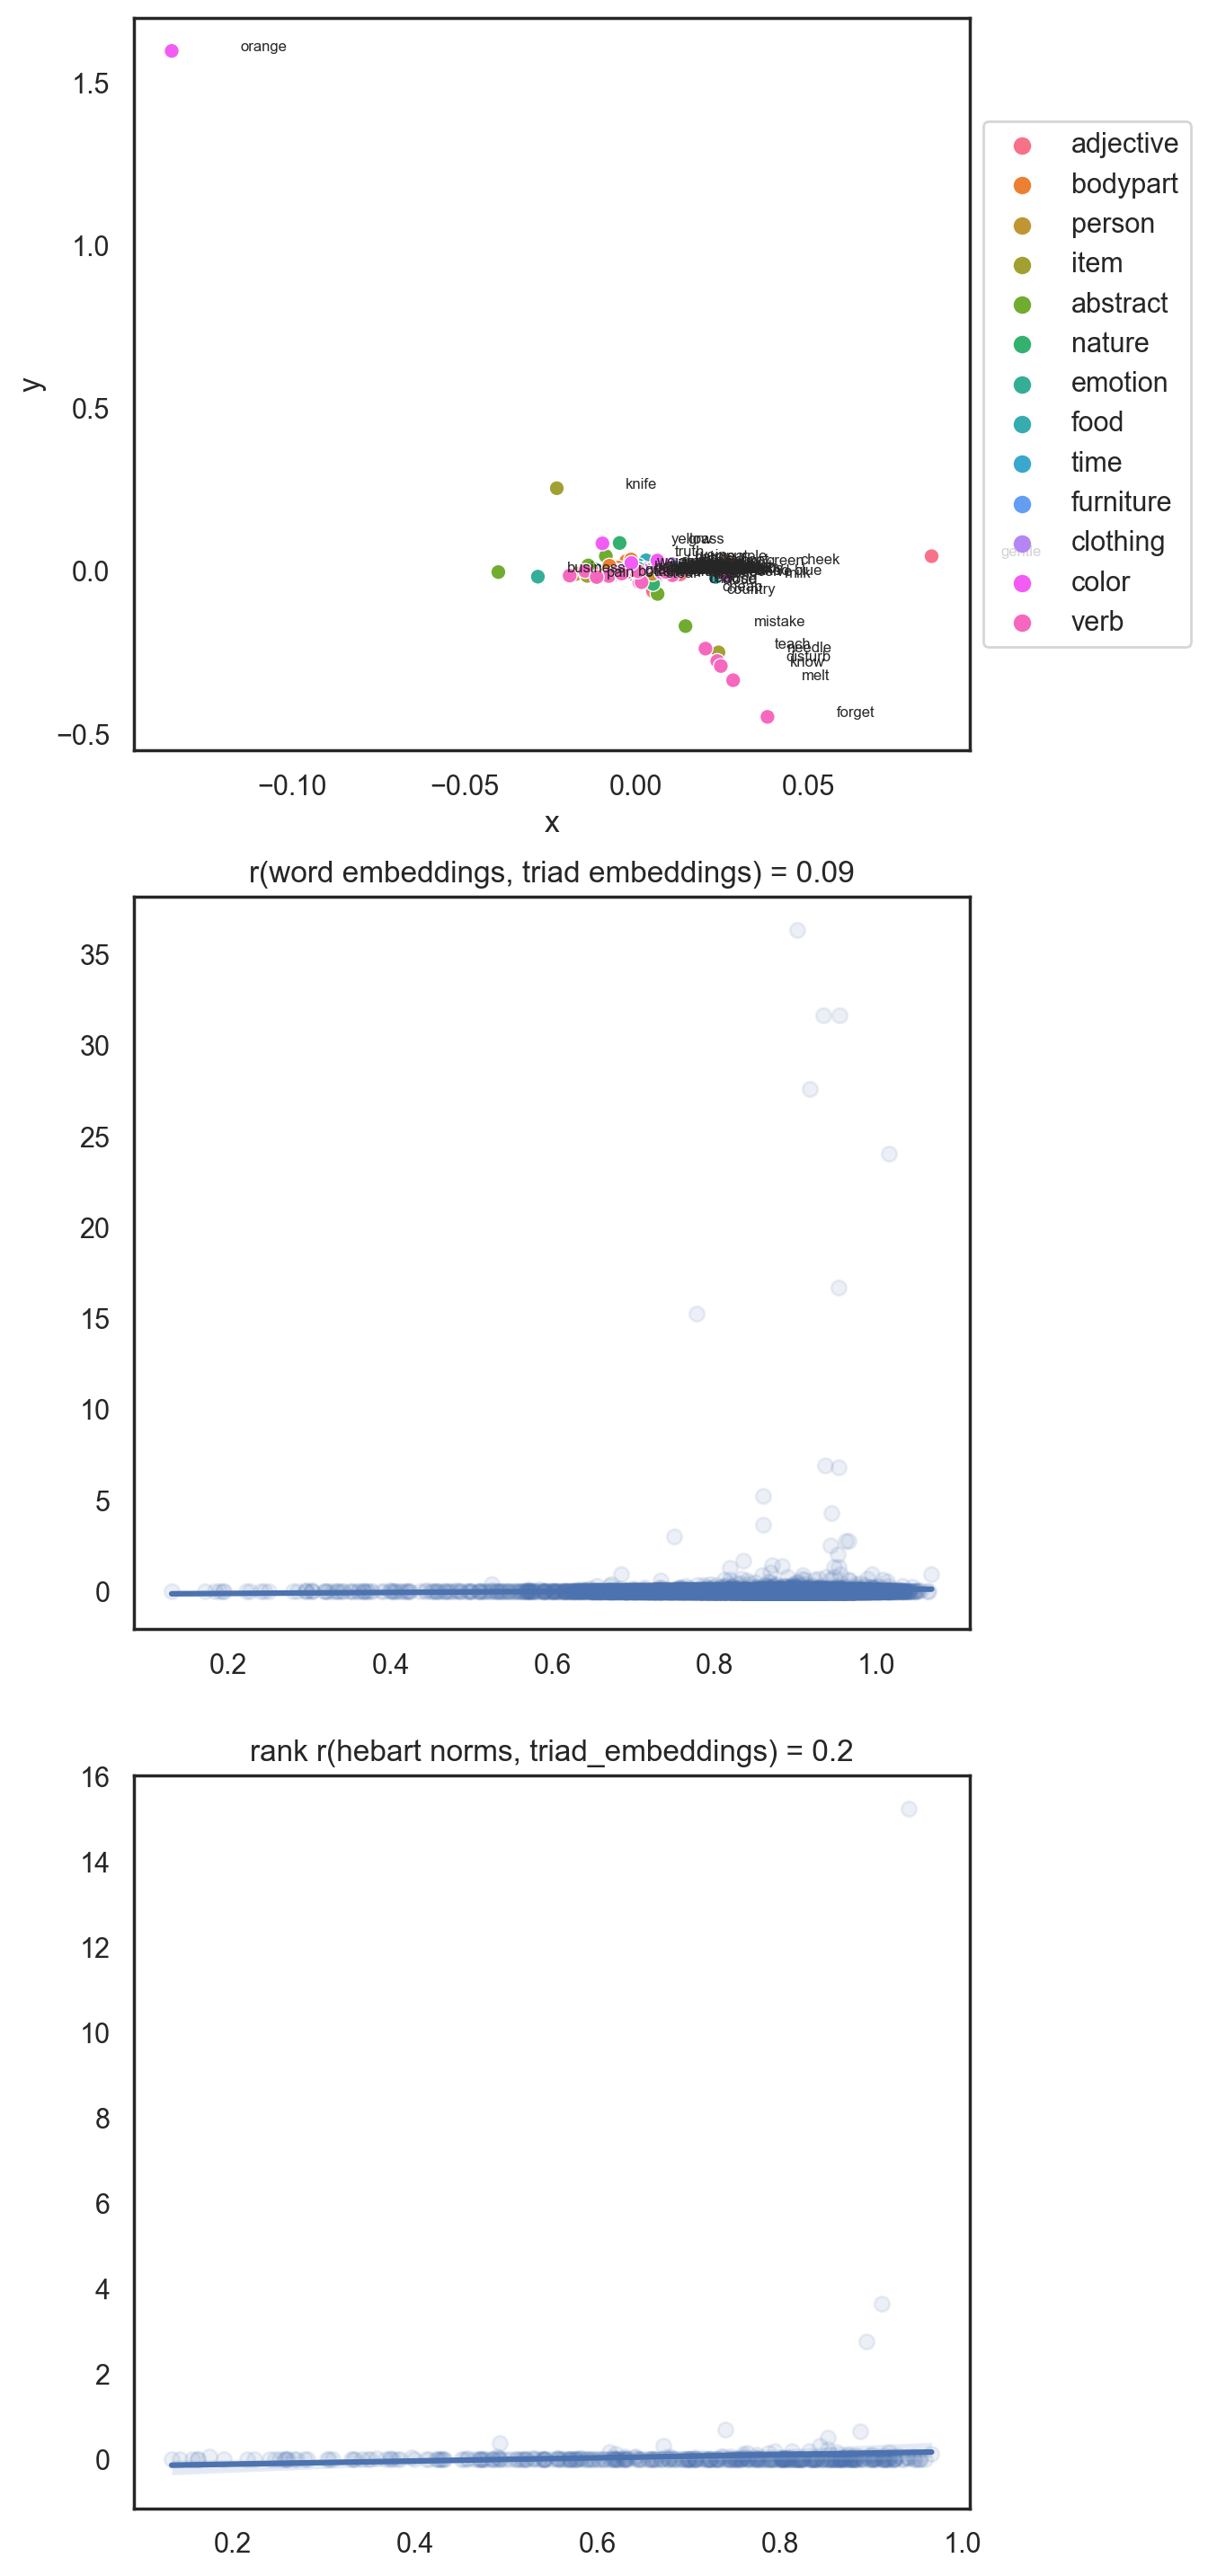

In [7]:
es.evaluate_embeddings(mds, concepts)

# Match-to-middle triad task with 75 concepts
## 0 (reject) and 1 (match) values

In [8]:
idxarrangs, concepts = es.preprocess_novel_triads(verbose=True)
display(concepts)

pp A107RJSS561Y7R catch trial pass rate: 1.00 out of 11 catch and 171 overall trials
pp A10AVWALIHR4UQ catch trial pass rate: 1.00 out of 15 catch and 218 overall trials
pp A11LNK1U3DT08V catch trial pass rate: 1.00 out of 9 catch and 166 overall trials
pp A11TOEFVA0X3PL catch trial pass rate: 0.38 out of 8 catch and 212 overall trials
pp A11YS0T8MV3Q7C catch trial pass rate: 0.57 out of 7 catch and 183 overall trials
pp A12FTSX85NQ8N9 catch trial pass rate: 1.00 out of 9 catch and 170 overall trials
pp A17K1CHOI773VZ catch trial pass rate: 1.00 out of 8 catch and 172 overall trials
pp A184MZVD0VRQDP catch trial pass rate: 1.00 out of 7 catch and 271 overall trials
pp A18E16UFE351U6 catch trial pass rate: 1.00 out of 8 catch and 172 overall trials
pp A18G2CLYSTENK catch trial pass rate: 1.00 out of 7 catch and 173 overall trials
pp A1B9H14AV44C0G catch trial pass rate: 1.00 out of 7 catch and 179 overall trials
pp A1BHR5XQ16T7LA catch trial pass rate: 1.00 out of 12 catch and 163 overa

prefix    concept    category  pos_gloss
0     NaN        bad   adjective  adjective
1     NaN  beautiful   adjective  adjective
2     NaN      cheap   adjective  adjective
3     NaN     clever   adjective  adjective
4     NaN       deaf   adjective  adjective
..    ...        ...         ...        ...
70     to       swim  bodymotion       verb
71     to       walk  bodymotion       verb
72     to        lay  bodymotion       verb
73     to        sit  bodymotion       verb
74     to      stand  bodymotion       verb

[75 rows x 4 columns]

In [9]:
embeddings = es.train_embeddings(idxarrangs, epochs=100)

0epoch [00:00, ?epoch/s]

/Users/jvparidon/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/jvparidon/Documents/Work/Projects/pastel-game/embedding_spaces.py:587: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concepts[['x', 'y']] = decomp.fit_transform(dists)


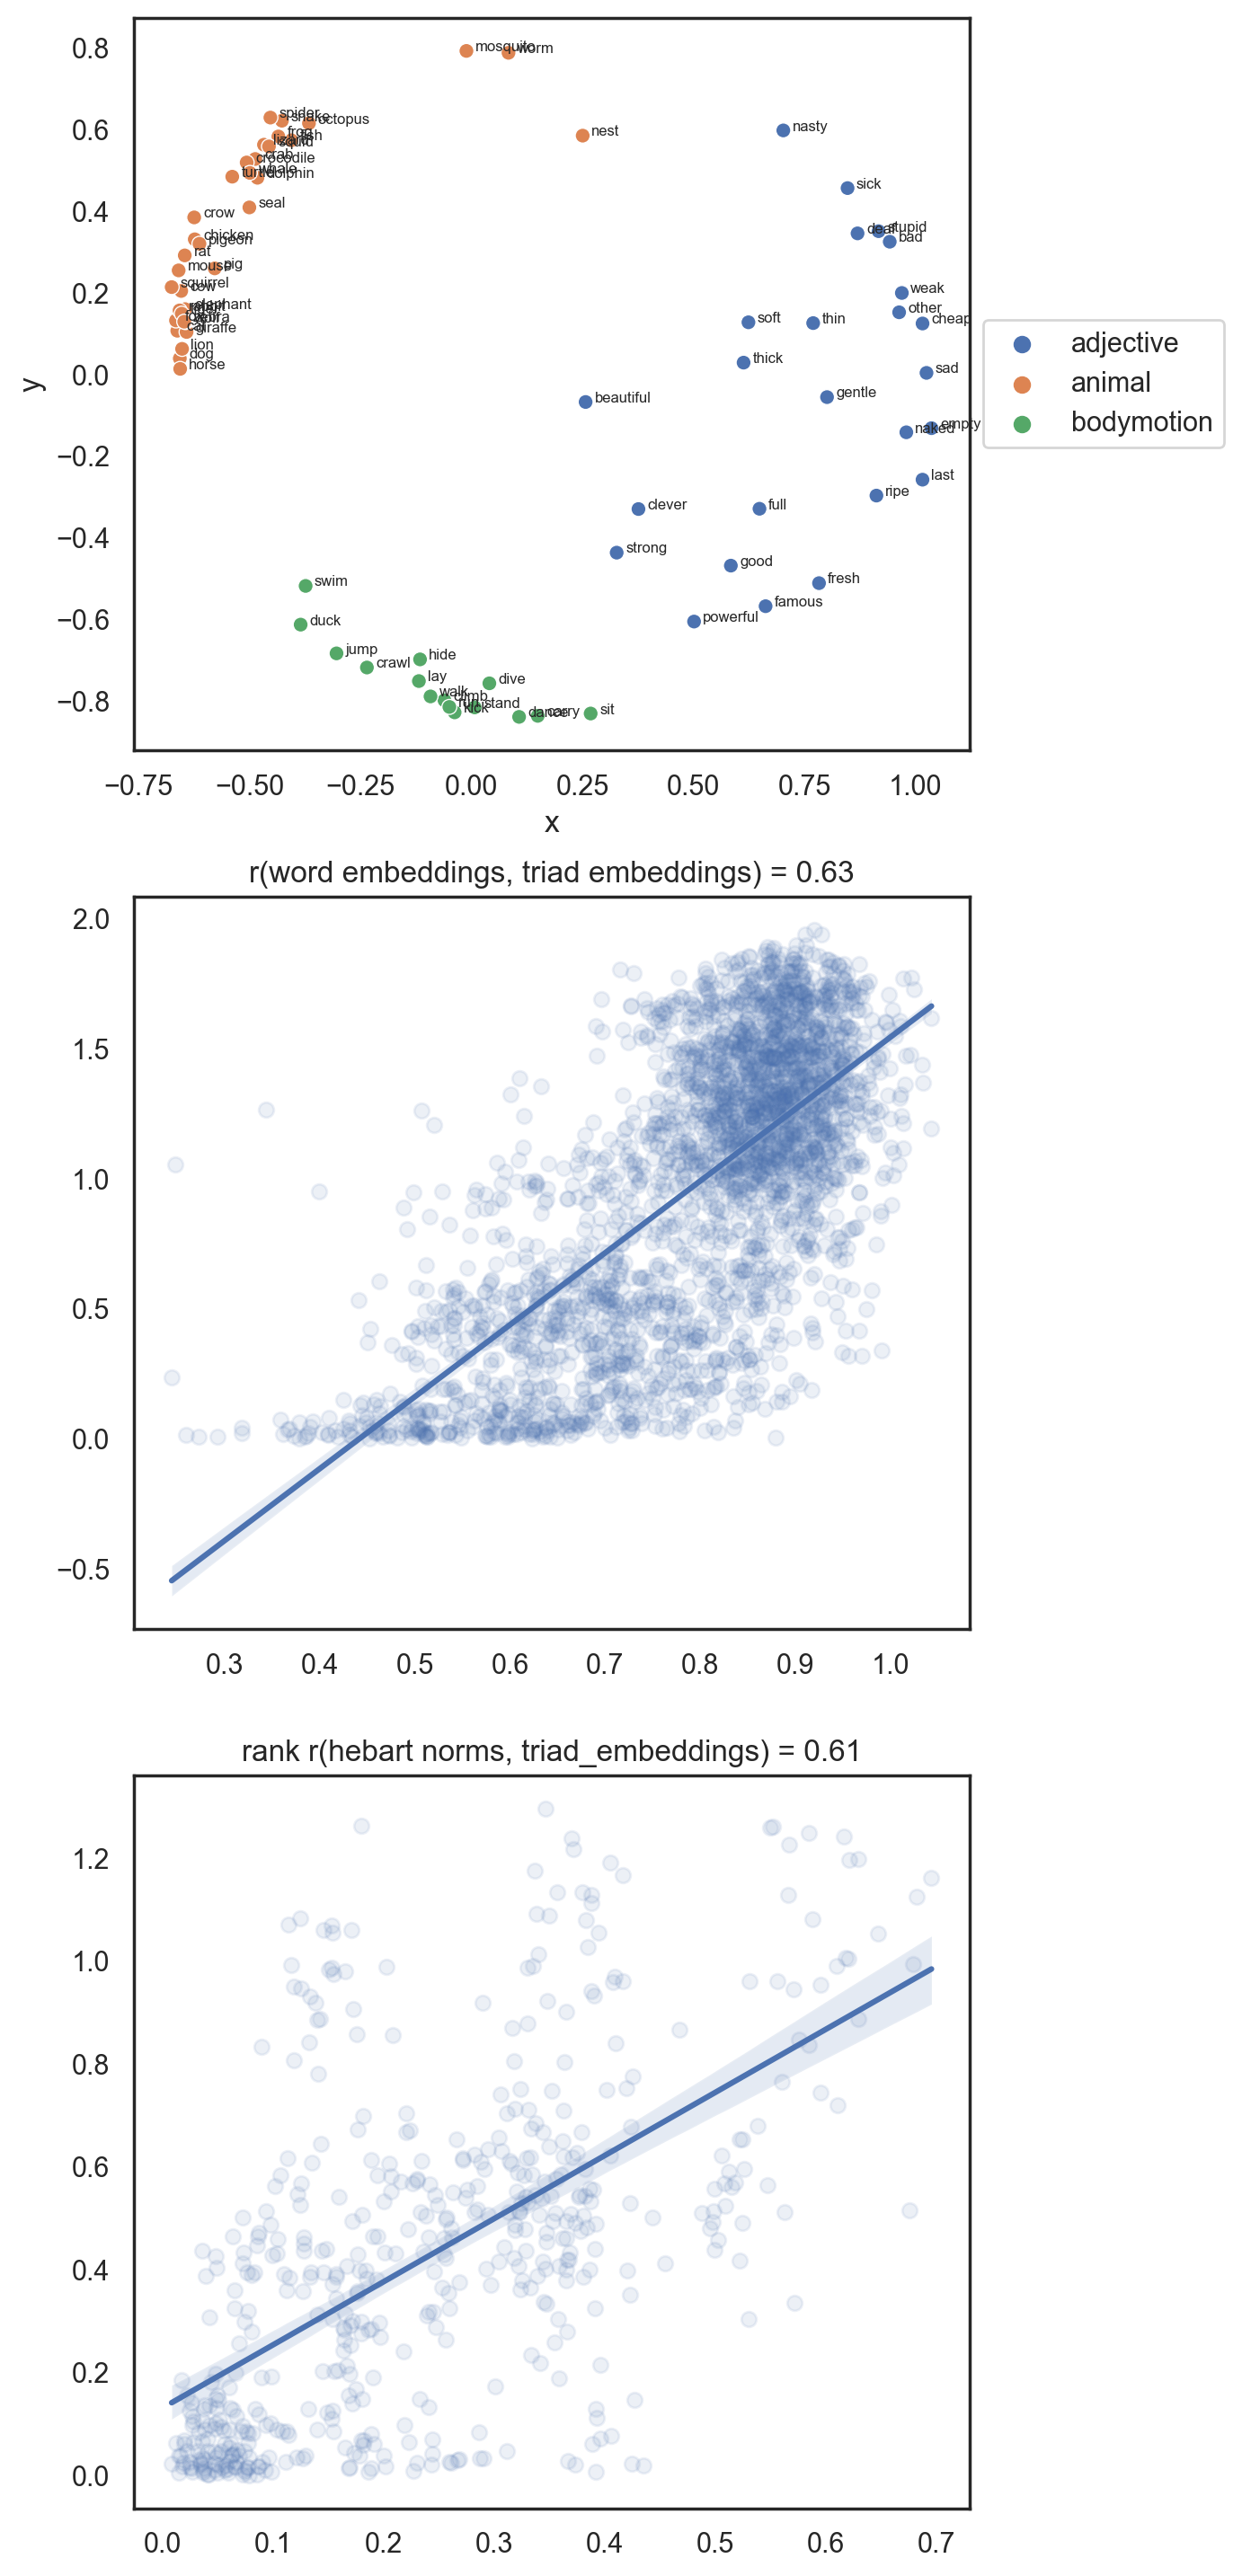

In [10]:
es.evaluate_embeddings(embeddings, concepts)
#es.evaluate_embeddings(embeddings, concepts, categories=['adjective'])

### Split-half correlations

In [36]:
# perform ten splits for stable estimate
print('split half rank correlation, sd across folds:')
es.splithalf_corr(idxarrangs, splits=10, epochs=100)

split half rank correlation, sd across folds:


  0%|          | 0/10 [00:00<?, ?it/s]

(0.85, 0.02)

In [41]:
steps = 10
pp = []
r = []
sd = []

for i in range(steps):
    frac = (i + 1) / steps
    n = int(len(idxarrangs) / (1 / frac))
    print(f"split half correlation for first {n} participants:")
    corr = es.splithalf_corr(idxarrangs, splits=8, epochs=100, frac=frac)
    print(corr)
    pp.append(n)
    r.append(corr[0])
    sd.append(corr[1])

split half correlation for first 4 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.06, 0.06)
split half correlation for first 9 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.3, 0.12)
split half correlation for first 14 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.51, 0.08)
split half correlation for first 19 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.62, 0.08)
split half correlation for first 24 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.69, 0.07)
split half correlation for first 29 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.71, 0.04)
split half correlation for first 34 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.75, 0.03)
split half correlation for first 39 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.8, 0.03)
split half correlation for first 44 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.83, 0.03)
split half correlation for first 49 participants:


  0%|          | 0/8 [00:00<?, ?it/s]

(0.84, 0.04)


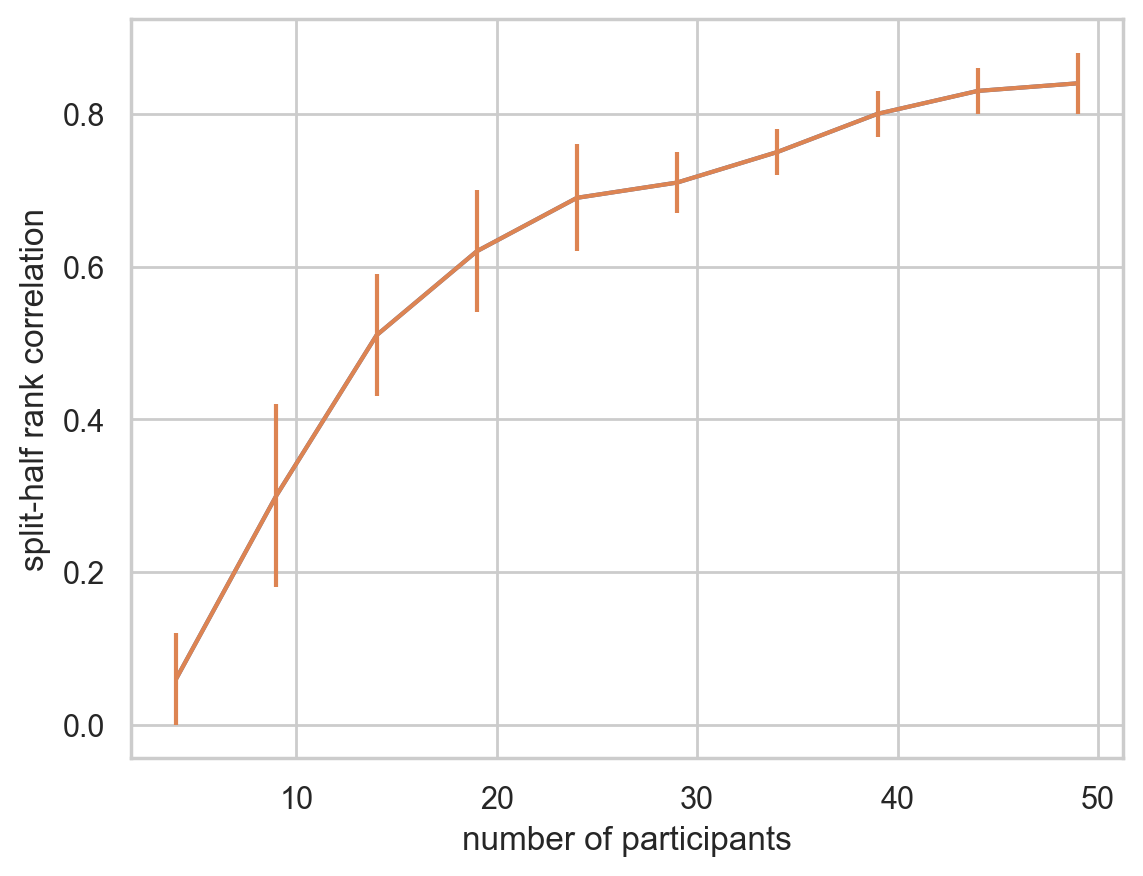

In [42]:
sns.set(style='whitegrid')
ax = sns.lineplot(x=pp, y=r)
ax.errorbar(x=pp, y=r, yerr=sd)
ax.set(ylabel='split-half rank correlation', xlabel='number of participants')
plt.savefig('splithalf_corr_75_concepts.pdf')

### Inverse MDS method from Kriegeskorte & Mur (2012)

In [11]:
mds = es.inverse_mds(idxarrangs)

/Users/jvparidon/Documents/Work/Projects/pastel-game/embedding_spaces.py:532: RuntimeWarning: invalid value encountered in divide
  mean_rdm = np.nan_to_num(rdm / evidence)
/Users/jvparidon/Documents/Work/Projects/pastel-game/embedding_spaces.py:561: RuntimeWarning: invalid value encountered in divide
  rdm = np.nan_to_num(rdm / evidence)


/Users/jvparidon/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/jvparidon/Documents/Work/Projects/pastel-game/embedding_spaces.py:587: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concepts[['x', 'y']] = decomp.fit_transform(dists)


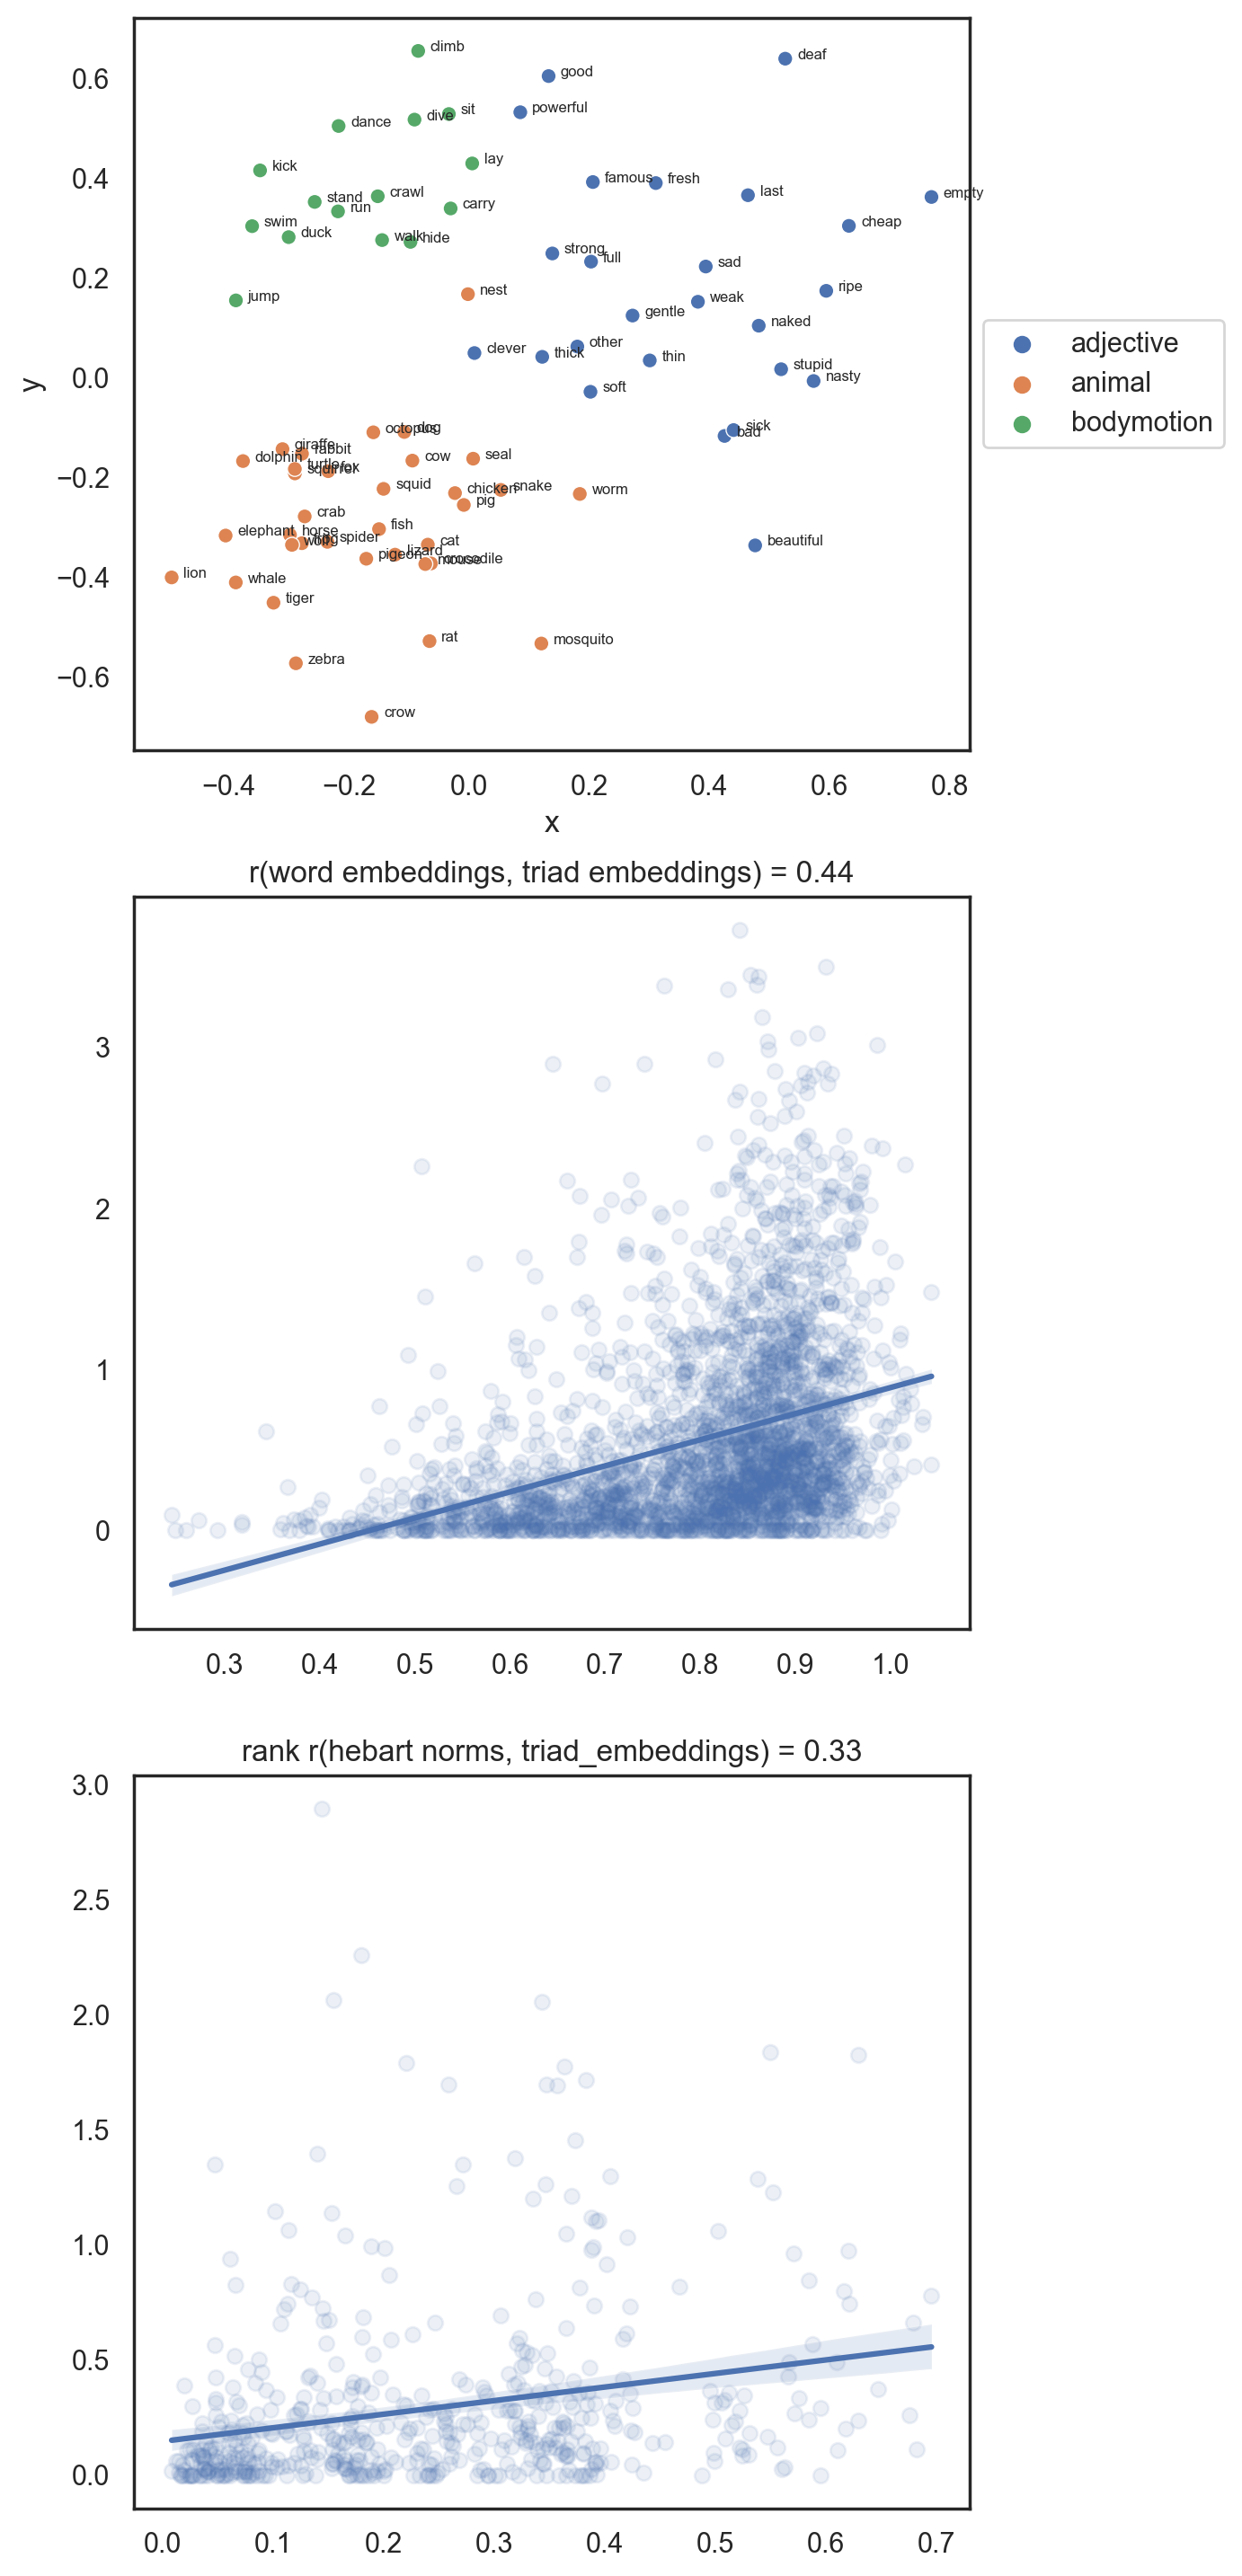

In [12]:
es.evaluate_embeddings(mds, concepts)